In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy
from wordfreq import zipf_frequency
import seaborn as sns
import os.path
from tqdm.notebook import tqdm

In [3]:
model = "en_core_web_lg"
nlp = spacy.load(model)

In [4]:
from parse_data import TextsinlevelsDB

In [5]:
textsinlevels = TextsinlevelsDB(db_name="textsinlevels")
df_news = textsinlevels.write_from_table_to_df("newsinlevels")
df_days = textsinlevels.write_from_table_to_df("daysinlevels")
del textsinlevels

In [6]:
LEVELS = ("A1", "A2", "B1", "B2", "C1", "C2")

In [7]:
class Text:
    def __init__(self, tokens):
        self.tokens = tokens
        self.lemmas = self.lemmatize()
    
    def lemmatize(self):
        return [token.lemma_.lower() for token in self.tokens
                       if token.is_alpha]
    
    def count_words(self):
        n_words = 0
        for token in self.tokens:
            if token.is_alpha:
                n_words += 1
        return n_words
    
    def count_sentences(self):
        n_sentences = 0
        for sent in self.tokens.sents:
            n_sentences += 1
        return n_sentences
    
    def count_type_token_ratio(self):
        return len(set(self.lemmas)) / len(self.lemmas) 
    
    def count_words_from_wordlist(self, wordlist):
        words_from_wordlists = 0
        
        for lemma in self.lemmas:
            if lemma in wordlist:
                words_from_wordlists += 1
        
        return words_from_wordlists / len(self.lemmas)
    
    def count_words_from_level_lists(self, word2level):
        level_freqs = {level: 0 for level in LEVELS}
        
        for lemma in self.lemmas:
            level = word2level.get(lemma)
            if level:
                level_freqs[level] += 1

        for level in level_freqs:
            level_freqs[level] /= len(self.lemmas)
            
        return level_freqs
    
    def count_zipf_freqs(self):
        zipf_freqs = {}
        
        for lemma in self.lemmas:
            zipf_freq = math.floor(zipf_frequency(lemma, "en"))
            if zipf_freq in zipf_freqs:
                zipf_freqs[zipf_freq] += 1
            else:
                zipf_freqs[zipf_freq] = 1
        
        for zipf_freq in zipf_freqs:
            zipf_freqs[zipf_freq] /= len(self.lemmas)
        
        return zipf_freqs

In [8]:
class TextDataset:
    def __init__(self, dataset, dataset_name, nlp, preprocess):
        self.dataset_name = dataset_name
        self.dataset = dataset
        if preprocess:
            docs = spacy.tokens.DocBin(store_user_data=False)
            for doc in nlp.pipe(tqdm(self.dataset["article_text"])):
                docs.add(doc)
            docs.to_disk(self.dataset_name)
        else:
            docs = spacy.tokens.DocBin().from_disk(self.dataset_name)
        self.texts = [Text(doc) for doc in docs.get_docs(spacy.blank("en").vocab)]
    
    def count_words(self):
        return [text.count_words() for text in self.texts]
    
    def count_sentences(self):
        return [text.count_sentences() for text in self.texts]
    
    def lemmatize(self):
        return [text.lemmatize() for text in self.texts]
    
    def count_type_token_ratio(self):
        return [text.count_type_token_ratio() for text in self.texts]
    
    def count_words_from_wordlist(self, wordlist):
        return [text.count_words_from_wordlist(wordlist) for text in self.texts]
    
    def count_words_from_level_lists(self, word2level):
        return [text.count_words_from_level_lists(word2level) for text in self.texts]
        
    def count_zipf_freqs(self):
        return [text.count_zipf_freqs() for text in self.texts]
                
    def show_counts_info(self):
        print(self.dataset_name)
        d = {"Number of words": self.count_words(),
            "Number of sentences": self.count_sentences()}
        df_stats = pd.DataFrame(d)
        print(df_stats.describe())

        f = plt.figure(figsize=(10, 4))
        plt.suptitle(self.dataset_name)
        gs = f.add_gridspec(1, 2)

        for i, col in enumerate(d):
            ax = f.add_subplot(gs[0, i])
            ax = sns.distplot(df_stats[col], bins=20)

        plt.show()
        f.savefig(f"{self.dataset_name}-words_sentences_counts.png")
    
    def create_lexical_df(self, abstract_nouns, concrete_nouns):
        dct_lexical = {"words": [" ".join(self.texts[i].lemmas) for i in range(len(self.texts))],
                       "word_count": self.count_words(),
                       "type_token_ratio": self.count_type_token_ratio(),
                       "abstract_nouns": self.count_words_from_wordlist(abstract_nouns),
                       "concrete_nouns": self.count_words_from_wordlist(concrete_nouns),
                       "level": self.dataset["level"]}
                       
        zipf_freqs = self.count_zipf_freqs()
        
        for i in range(1, 7):
            dct_lexical[f"zipf_freqs_{i}"] = [dct.get(i, 0) for dct in zipf_freqs]
        
        for level in LEVELS:
            dct_lexical[level] = [dct[level] for dct in self.count_words_from_level_lists(word2level)]
        
        df_lexical = pd.DataFrame(dct_lexical)
        return df_lexical

In [9]:
def preprocess_word_list(filename):
    with open(f"wordlists/{filename}", encoding='utf-8') as f:
        words_from_list = f.read().split('\n')
        
    words_from_list = ' '.join([w for w in words_from_list if " " not in w and "-" not in w])
    words_from_list = nlp(words_from_list)
    words_from_list = set(w.lemma_.lower() for w in words_from_list)
    return words_from_list

In [10]:
abstract_nouns = preprocess_word_list("abstract_nouns.txt")
concrete_nouns = preprocess_word_list("concrete_nouns.txt")
print(len(abstract_nouns), len(concrete_nouns))

160 384


In [11]:
def create_word2level_dct():
    dct = {}
    df = pd.read_csv("wordlists/Vocabulary Framework – British English.csv")
    sub_df = df[["Base Word", "Level"]]
    sub_df_min = sub_df.groupby("Base Word").min()
    for d, data in sub_df_min.reset_index().groupby("Level"):
        dct[d] = list(data["Base Word"])
    
    word2level = {}
    for level, words in dct.items():
        for i in range(len(words)):
            if ' ' not in words[i]:
                word2level[words[i].lower()] = level
    
    return word2level

In [12]:
word2level = create_word2level_dct()

In [160]:
news = TextDataset(dataset=df_news, dataset_name="news", nlp=nlp, preprocess=False)
days = TextDataset(dataset=df_days, dataset_name="days", nlp=nlp, preprocess=False)

news_lexical_df = news.create_lexical_df(abstract_nouns, concrete_nouns)
days_lexical_df = days.create_lexical_df(abstract_nouns, concrete_nouns)

news_lexical_df['level'] = news_lexical_df['level'].map({1:0, 2:1, 3:2}) 
Y = news_lexical_df["level"]
X = news_lexical_df.drop(columns=["level"])

In [161]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import mord

In [162]:
class MyTfidfVectorizer(TfidfVectorizer):
        
    def fit_transform(self, raw_documents, y):
        X = TfidfVectorizer.fit_transform(self, raw_documents, y=None)
        return X/X.sum(axis=1)

    def transform(self, raw_documents):
        X = TfidfVectorizer.transform(self, raw_documents)
        return X/X.sum(axis=1)

In [163]:
def visualize_coefs(estimator, n_top_features, filename):
     
    coef = estimator[-1].coef_
    n_classes = coef.shape[0]
    feature_names = np.array(estimator.named_steps['vectorizer'].get_feature_names())
    print(len(feature_names))
    

    for n in range(n_classes):
        print('class', n)
        coefs = np.argsort(coef[n])
        
        if len(feature_names) > 2 * n_top_features:
            # индексы признаков, получивших cамые большие положительные коэффициенты
            pos_coefs = coefs[-n_top_features:]

            # индексы признаков, получивших самые низкие отрицательные коэффициенты
            neg_coefs = coefs[:n_top_features]

            interesting_coefs = np.hstack([neg_coefs, pos_coefs])

            plt.figure(figsize=(9, 3))
            colors = ["red" if c < 0 else "green" for c in coef[n][interesting_coefs]]
            plt.bar(np.arange(2 * n_top_features), coef[n][interesting_coefs], color=colors)
            plt.xticks(np.arange(2 * n_top_features), feature_names[interesting_coefs], rotation=90, ha="right")
        else:
            colors = ["red" if c < 0 else "green" for c in coef[n][coefs]]
            plt.bar(np.arange(len(feature_names)), coef[n][coefs], color=colors)
            plt.xticks(np.arange(len(feature_names)), feature_names[coefs], rotation=90, ha="right")
        
        directory = "illustrations"
        if not os.path.exists("illustrations"):
            os.makedirs(directory)
            
        plt.savefig(os.path.join(directory, f"{filename}_class{n}.png"), bbox_inches='tight')
        plt.show()

In [164]:
def visualize_feature_importances(estimator, n_top_features, filename):
    coef = estimator[-1].feature_importances_
    feature_names = np.array(estimator.named_steps['vectorizer'].get_feature_names())
    word_importances = pd.Series(coef, index=feature_names).sort_values(ascending=False)[:10]
    word_importances.plot(kind='bar')
    plt.tight_layout()
    plt.savefig(os.path.join("illustrations", filename), bbox_inches='tight')
    plt.show()
    return feature_names

In [165]:
class PassthroughTransformer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        self.X = X
        return X

    def get_feature_names(self):
        return self.X.columns.tolist()

In [166]:
def quality(y_actual, y_pred):
    acc = accuracy_score(y_actual, y_pred)
    f1 = f1_score(y_actual, y_pred, average="macro")
    print(f"Accuracy: {acc:.4f}\nF1 macro: {f1:.4f}")
    
    cm = confusion_matrix(y_actual, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", annot_kws={"size": 16})
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()

    return acc, f1

In [167]:
scaler = MaxAbsScaler()
vectorizer = MyTfidfVectorizer()

In [200]:
lr = LogisticRegression(solver="liblinear")
svm = LinearSVC()
tree = DecisionTreeClassifier()
adaboost = AdaBoostClassifier()
random_forest = RandomForestClassifier()
extra_trees = ExtraTreesClassifier()
lgbm = LGBMClassifier()
logistic_at = mord.LogisticAT()
logistic_it = mord.LogisticIT()
logistic_se = mord.LogisticSE()
ordinal_ridge = mord.OrdinalRidge()
lad = mord.LAD()

In [226]:
lr_params = dict(vectorizer__word__min_df=[3, 5, 7], lr__C=[0.1, 0.5, 1], lr__penalty=["l1", "l2"])
svm_params = dict(vectorizer__word__min_df=[3, 5, 7], svm__C=[0.01, 0.1, 1])
tree_params = dict(vectorizer__word__min_df=[3, 5, 7], tree__max_depth=[None, 7, 10],
                tree__min_samples_leaf=[1, 10])
adaboost_params = dict(vectorizer__word__min_df=[3, 5, 7], adaboost__base_estimator=[DecisionTreeClassifier(max_depth=1),
                        DecisionTreeClassifier(max_depth=2)])
random_forest_params = dict(vectorizer__word__min_df=[3, 5, 7], random_forest__max_depth=[None, 10],
                       random_forest__min_samples_leaf=[1, 5])
extra_trees_params = dict(vectorizer__word__min_df=[3, 5, 7], extra_trees__max_depth=[None, 15],
                       extra_trees__min_samples_leaf=[1, 15])
lgbm_params = dict(vectorizer__word__min_df=[3, 5, 7], lgbm__min_split_gain=[0, 0.5], lgbm__colsample_bytree=[0.25, 0.5, 1])
logistic_at_params = dict(vectorizer__word__min_df=[3, 5, 7], logistic_at__alpha=[0.5, 1, 5])
logistic_it_params = dict(vectorizer__word__min_df=[3, 5, 7], logistic_it__alpha=[0.5, 1, 5])
logistic_se_params = dict(vectorizer__word__min_df=[3, 5, 7], logistic_se__alpha=[0.5, 1, 5])
ordinal_ridge_params = dict(vectorizer__word__min_df=[3, 5, 7], ordinal_ridge__alpha=[0.5, 1, 5])
lad_params = dict(vectorizer__word__min_df=[3, 5, 7], lad__C=[0.01, 0.1, 1])

In [227]:
clfs = {
    "lr": [lr, lr_params],
    "svm": [svm, svm_params],
    "tree": [tree, tree_params],
    "adaboost": [adaboost, adaboost_params],
    "random_forest": [random_forest, random_forest_params],
    "extra_trees": [extra_trees, extra_trees_params],
    "lgbm": [lgbm, lgbm_params],
    "lad": [lad, lad_params],
    "ordinal_ridge": [ordinal_ridge, ordinal_ridge_params],
    "logistic_se": [logistic_se, logistic_se_params],
    "logistic_at": [logistic_at, logistic_at_params],
    "logistic_it": [logistic_it, logistic_it_params],
}

In [228]:
tree_based = {"tree", "adaboost", "random_forest", "extra_trees", "lgbm"}
with_coefs = {"lr", "svm"}

In [229]:
column_trans = ColumnTransformer(
            [('word', vectorizer, "words"), 
            ('feature', PassthroughTransformer(), [*lexical_features])])

In [230]:
lexical_features = ['zipf_freqs_1', 'zipf_freqs_2', 'zipf_freqs_3', 'zipf_freqs_4',
       'zipf_freqs_5', 'zipf_freqs_6', 'A1', 'A2', 'B1', 'B2', 'C1', 'C2',
       'type_token_ratio', 'abstract_nouns', 'concrete_nouns']

grammatical_features = []

all_features = lexical_features + grammatical_features

In [231]:
features = {"lexical": lexical_features,
            "grammatical": grammatical_features,
            "all": all_features}

In [232]:
results = {}

for feature_set in features:
    results[feature_set] = {"F1 macro (validation)": {},
                        "Best params": {},
                        "Accuracy (test)": {},
                        "F1 macro (test)": {}
                       }

In [233]:
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

In [234]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    train_size=0.8, 
                                                    random_state=42,
                                                   stratify=Y)

In [235]:
for clf_name, clf_params in clfs.items():
    clf, params = clf_params
    if clf_name in tree_based:
        pipeline = Pipeline(steps=[("vectorizer", column_trans), (clf_name, clf)])
    else:
        pipeline = Pipeline(steps=[("vectorizer", column_trans), ("scaler", scaler), (clf_name, clf)])
    grid_search = GridSearchCV(pipeline, param_grid=params,
                           scoring={"F1": "f1_macro", "Accuracy": "accuracy"},
                           refit="F1", return_train_score=True, cv=skf, verbose=10) 
    grid_search.fit(X_train, y_train)
    best_f1_val = round(grid_search.best_score_, 4)
    best_params = grid_search.best_params_
    print(f"Best f1 on validation: {best_f1_val}")
    print("Best parameters:", best_params, "\n")
    estimator = grid_search.best_estimator_
    
    y_pred_test = estimator.predict(X_test)
    acc, f1 = quality(y_test, y_pred_test)
    
    for metric, value in {"F1 macro (validation)": best_f1_val,
                          "Best params": best_params,
                          "Accuracy (test)": round(acc, 4),
                          "F1 macro (test)": round(f1, 4)}.items():
        results["lexical"][metric][clf_name] = value
        
    if clf_name in tree_based:
        feature_names = visualize_feature_importances(estimator, 10, "lexical_" + clf_name)
    elif clf_name in with_coefs:
        visualize_coefs(estimator, 10, "lexical_" + clf_name)

Fitting 4 folds for each of 12 candidates, totalling 48 fits
[CV 1/4; 1/12] START lad__C=0.01, vectorizer__word__min_df=3....................
[CV 1/4; 1/12] END lad__C=0.01, vectorizer__word__min_df=3; Accuracy: (train=0.858, test=0.811) F1: (train=0.862, test=0.815) total time=   2.4s
[CV 2/4; 1/12] START lad__C=0.01, vectorizer__word__min_df=3....................
[CV 2/4; 1/12] END lad__C=0.01, vectorizer__word__min_df=3; Accuracy: (train=0.858, test=0.808) F1: (train=0.861, test=0.814) total time=   2.3s
[CV 3/4; 1/12] START lad__C=0.01, vectorizer__word__min_df=3....................
[CV 3/4; 1/12] END lad__C=0.01, vectorizer__word__min_df=3; Accuracy: (train=0.854, test=0.822) F1: (train=0.857, test=0.826) total time=   2.3s
[CV 4/4; 1/12] START lad__C=0.01, vectorizer__word__min_df=3....................
[CV 4/4; 1/12] END lad__C=0.01, vectorizer__word__min_df=3; Accuracy: (train=0.855, test=0.836) F1: (train=0.859, test=0.840) total time=   2.3s
[CV 1/4; 2/12] START lad__C=0.01, v

KeyboardInterrupt: 

In [ ]:
baseline = y_test.value_counts(normalize=True).max()

# for feature_set in ("lexical features", "morphological and syntactic features", "all features"):
mini_df = pd.DataFrame(results["lexical"])
mini_df.head()

In [338]:
results

{'lexical': {'F1 macro (validation)': {'lr': 0.8521},
  'Best params': {'lr': {'lr__penalty': 'l1', 'vectorizer__word__min_df': 7}},
  'Accuracy (test)': {'lr': 0.8518},
  'F1 macro (test)': {'lr': 0.8512}}}


lexical


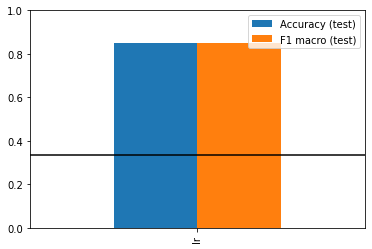

Best result:
Accuracy (test): 0.8518
F1 macro (test): 0.8512


In [361]:
baseline = y_test.value_counts(normalize=True).max()

# for feature_set in ("lexical features", "morphological and syntactic features", "all features"):
for feature_set in ("lexical",):
    mini_df = pd.DataFrame(results[feature_set])
    mini_df.to_csv(f"{feature_set}-results.csv")
    print(f"\n{feature_set}")
    mini_df[['Accuracy (test)', 'F1 macro (test)']].plot.bar()
    plt.axhline(y=baseline, color="k")
    plt.ylim(0, 1)
    plt.savefig(f"{feature_set}-results.png", bbox_inches='tight')
    plt.show()
    
    print("Best result:")
    
    max_value = 0
    best_clf = ""
    for clf, value in results[feature_set]["F1 macro (test)"].items():
        if value > max_value:
            best_clf = clf
    
    for metric in ("Accuracy (test)", "F1 macro (test)"):
        print(f"{metric}: {results[feature_set][metric][clf]}")

In [ ]:
results